<a href="https://colab.research.google.com/github/radu-dumitru/micrograd_from_scratch/blob/main/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [468]:
import math
from graphviz import Digraph
import random

In [469]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data ** other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other ** -1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other ): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2 * x) -1) / (math.exp(2 * x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t ** 2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):
    # topological sort = a laying out a graph such that all the edges go only from left to right
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [470]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

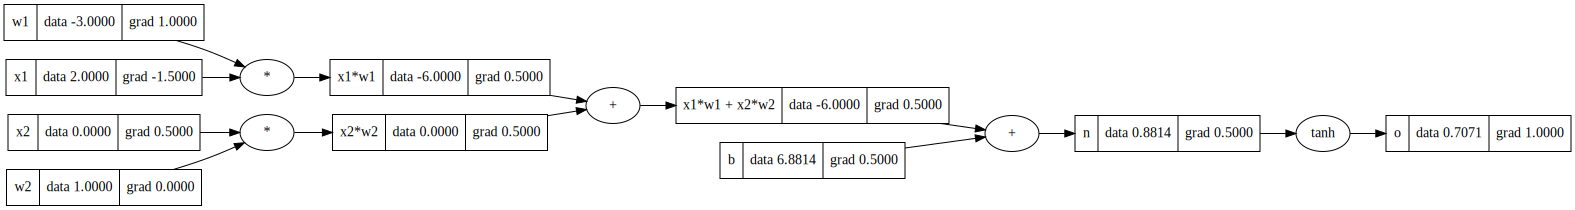

In [471]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)


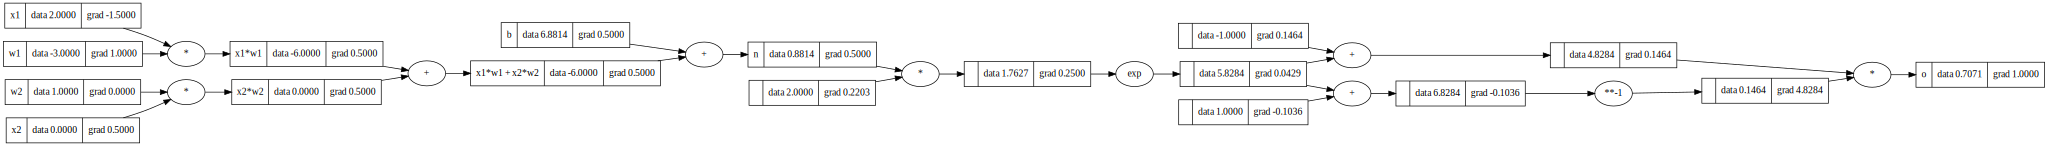

In [472]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2 * n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'

o.backward()
draw_dot(o)

In [473]:
class Neuron:

  def __init__(self, nin): # nin = number of inputs
    # w = weights
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    # b = bias
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    # w * x is a dot product
    # x is an array of values

    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()

    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    # nout = how many neurons you want in this layer
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params

class MLP:

  def __init__(self, nin, nouts):
    # nouts is a list and defines the sizes of all the layers that we want in our MLP
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [474]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

# draw_dot(n(x))

n.parameters()

[Value(data=-0.5056142337773202),
 Value(data=0.5360348822637493),
 Value(data=-0.8400770513348437),
 Value(data=0.5120394724989827),
 Value(data=0.7306263433923001),
 Value(data=-0.19910450512978328),
 Value(data=0.1005976576773544),
 Value(data=-0.9171399077672657),
 Value(data=0.3985280158418225),
 Value(data=-0.6789835527450157),
 Value(data=-0.5571045870113165),
 Value(data=0.1652467420226984),
 Value(data=0.026973470719338977),
 Value(data=-0.19480693705350505),
 Value(data=-0.555823231621366),
 Value(data=-0.5098866613959987),
 Value(data=0.32770461318488353),
 Value(data=-0.9716425627143674),
 Value(data=-0.3034108774815325),
 Value(data=0.9274083063320522),
 Value(data=0.4141234063709338),
 Value(data=0.173310884585254),
 Value(data=0.4402821175359297),
 Value(data=-0.26074892636797475),
 Value(data=-0.6251028225906865),
 Value(data=0.7165467818267546),
 Value(data=0.6781271314403858),
 Value(data=0.6157722493150468),
 Value(data=0.2724175426550848),
 Value(data=0.730410865176

In [475]:
# dataset

xs = [
    [2.0, 3.0, -1.0], # the network should return 1.0
    [3.0, -1.0, 0.5], # the network should return -1.0
    [0.5, 1.0, 1.0],  # the network should return -1.0
    [1.0, 1.0, -1.0]  # the network should return 1.0
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]

  # loss = a single number that measures the total performance of your neural net, it measures how well the neural net is performing
  # ygt = y ground truth
  # yout = y output
  # mean squared error
  # you only get 0 when yout is equal to ygt (the prediction is the target)
  # the more off we are the greater the loss will be, we want low loss
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 7.4927356859704455
1 3.373042146433297
2 3.0631972664279807
3 2.888131291945073
4 2.746439184270508
5 2.624770795972512
6 2.5022992196841902
7 2.3599213137154056
8 2.1793188812387716
9 1.9448789058598754
10 1.6556552533046605
11 1.33922476146408
12 1.0423265565191642
13 0.7997047578894818
14 0.6185145238179636
15 0.4883312009253381
16 0.3950411912752977
17 0.3271151134282456
18 0.27650898303427546
19 0.23788758044701247


In [476]:
ypred

[Value(data=0.7613305831838281),
 Value(data=-0.9835610916774856),
 Value(data=-0.6493079585031603),
 Value(data=0.7598555762721448)]

In [477]:
n = MLP(2, [4, 4, 1])

dataset = [
    [[1.0, 2.0], [1.0]],
    [[10.0, 5.0], [1.0]],
    [[88.0, 130.0], [1.0]],
    [[-3.0, 4.0], [-1.0]],
    [[-35.0, 25.0], [-1.0]],
    [[-99.0, 18.0], [-1.0]],
    [[5.0, -18.0], [-1.0]],
    [[10.0, -5.0], [-1.0]],
    [[85.0, -89.0], [-1.0]],
    [[-7.0, -8.0], [-1.0]],
    [[-80.0, -10.0], [-1.0]],
    [[-29.0, -50.0], [-1.0]],
]

xs = []
ys = []

for dataSetItem in dataset:
  xs.append(dataSetItem[0])
  ys.append(dataSetItem[1][0])

In [478]:
for k in range(100):
  # forward pass
  ypred = [n(x) for x in xs]

  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 22.57973281218561
1 10.32349132145087
2 1.752899766301332
3 0.975056636048115
4 0.3901799535678651
5 0.2427524811355104
6 0.20099359718778995
7 0.17308971942176235
8 0.1523062615899159
9 0.13602998823385082
10 0.12288333406310778
11 0.11202572357386298
12 0.10290177366256474
13 0.095125529100532
14 0.08841892238561268
15 0.0825759539193311
16 0.07744052259119907
17 0.07289207430090174
18 0.06883598112255394
19 0.06519690593339753
20 0.06191411567402192
21 0.05893810251073915
22 0.05622810395972799
23 0.053750253768313584
24 0.051476183477438604
25 0.049381951251474154
26 0.04744721183922038
27 0.04565456655768872
28 0.04398904930104309
29 0.04243771646808244
30 0.040989317088866044
31 0.039634025427798196
32 0.038363222681886376
33 0.03716931757230718
34 0.03604559798087249
35 0.03498610754244285
36 0.03398554243196711
37 0.03303916459534345
38 0.03214272844873054
39 0.03129241867054709
40 0.030484797177405383
41 0.029716757741439677
42 0.028985486995519404
43 0.028288430802347532
44

In [479]:
assert round(n([9.0, 82.0]).data) == 1
assert round(n([25.0, 125.0]).data) == 1
assert round(n([-18.0, 20.0]).data) == -1
assert round(n([3.0, -98.0]).data) == -1
assert round(n([-98.0, -78.0]).data) == -1